# import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras , os , tqdm , cv2
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , BatchNormalization , Dropout , Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [3]:
import os

# Устанавливаем рабочую директорию туда, где лежат данные
os.chdir("/Users/elmansulejmanov/Desktop/Задача №1 Сортировка токсичных комментариев")
print("Рабочая директория теперь:", os.getcwd())
print("Содержимое:", os.listdir())


Рабочая директория теперь: /Users/elmansulejmanov/Desktop/Задача №1 Сортировка токсичных комментариев
Содержимое: ['housing.csv', 'tensorflow_checklist.ipynb', 'Мой первый портфолио проект accuracy-99.ipynb', 'adult.csv', 'all_letters_info.csv', 'gym_churn.csv', 'Mall_Customers.csv', '.DS_Store', 'images.jpeg', 'y_true.npy', '3 Задачи matplotlib.ipynb', 'StudentsPerformance.csv', 'labeled.csv', 'Курсы по Machine Learning Engineering .ipynb', 'test.csv', '1 Pandas.ipynb', 'heart.csv', 'submission_blend3_weighted_047.csv', 'test.json', 'asl_alphabet_test', 'Telegram bot.ipynb', 'Задача Kaggle #2', 'Задача2.ipynb', 'Тренировка.ipynb', '2 matlplotlib.ipynb', 'tmp.csv', 'train.json', '4 Машинное обучение sklearn.ipynb', 'app.py', 'train.csv', '.ipynb_checkpoints', 'asl_alphabet_train', 'ЗАДАЧА1.ipynb', '6 Создание нейросетей TenserFlow.ipynb', 'asl_model.h5', 'Тренировка №1.ipynb', 'sosi.ipynb', 'test.ipynb', 'submission_catboost1.csv', 'Задача 1 Kaggle Score 0.80617.ipynb', 'catboost_info'

# Load Data

In [7]:
trainDir = 'asl_alphabet_train/asl_alphabet_train/'
testDir = 'asl_alphabet_test/asl_alphabet_test'

In [16]:
def loadTrsinData (trainDir , imageWidth , imageHight) :
  classes = os.listdir(trainDir)
  imagesList = []
  labels = []
  for clas in tqdm.tqdm(classes) :
    classesPath = os.path.join(trainDir,clas)
    for image in os.listdir(classesPath) :
      imgPath = os.path.join(trainDir,clas,image)
      img = cv2.imread(imgPath)
      img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img , (imageWidth , imageHight))
      imagesList.append(img)
      labels.append(clas)

  return imagesList , labels

# Explore Data

In [9]:
def displaySampleOfData (trainDir , imageWidth , imageHight) :
  plt.figure(figsize=(10,15))
  classes = os.listdir(trainDir)
  for i,clas in tqdm.tqdm(enumerate(classes)):
    plt.subplot(6,5,i+1)
    classesPath = os.path.join(trainDir,clas)
    image = os.listdir(classesPath)[0]
    image = os.path.join(trainDir,clas,image)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img , (imageWidth , imageHight))
    plt.title(clas)
    plt.imshow(img , cmap='gray')
  plt.show()


29it [00:00, 90.37it/s]


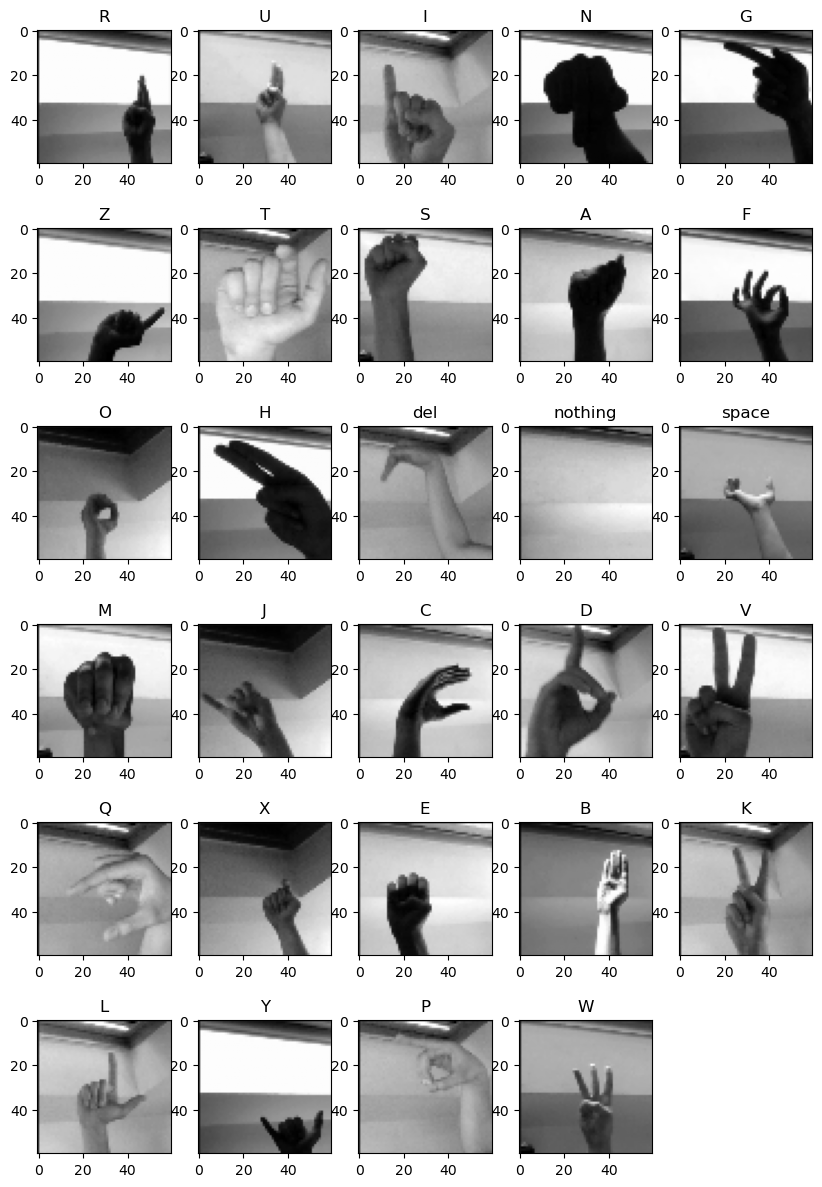

In [11]:
displaySampleOfData(trainDir ,60 ,60 )

In [18]:
# load data after explore the images and study it's case
X , y = loadTrsinData(trainDir , 60 , 60)

100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


In [19]:
testImages = []
testLabels = []
for img in tqdm.tqdm(os.listdir(testDir)):
  trainImagePath = os.path.join(testDir , img)
  image = cv2.imread(trainImagePath)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(60,60))
  testImages.append(image)
  testLabels.append(img)

100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 2192.81it/s]


# Data preprocessing

## train

In [24]:
# shuffles x and y to make better training
XShuffled , yShuffled = shuffle(X,y,random_state=42)

In [50]:
# convert list to np array
xtrain = np.array(XShuffled)
ytrain = np.array(yShuffled)

In [16]:
# shape of xtrain
xtrain.shape

(87000, 60, 60)

In [17]:
# Scale the train data
xtrain = xtrain.astype('float32') / 255.0

In [18]:
# Reshape xtrain to fit conv network
xtrainReshaped = xtrain.reshape( (87000, 60, 60 , 1) )

In [19]:
xtrainReshaped.shape

(87000, 60, 60, 1)

In [20]:
# Create list of classes and dic to convert y labels to numbers
cats = [i for i in os.listdir(trainDir)]
categories = {}
for i,c in enumerate(cats) :
  categories[c] = i

In [21]:
# convert labels in ytrain to numbers
for i in range (len(ytrain)) :
  ytrain[i] = categories[ytrain[i]]

ytrain

array(['19', '9', '11', ..., '25', '0', '5'], dtype='<U7')

In [22]:
# Convert ytrain from numpy array to categoricl formate to fit in the training
ytrain = to_categorical(ytrain)

## test

In [26]:
testImages = np.array(testImages)
testLabels = np.array(testLabels)

In [30]:
testImages = testImages.astype('float32') / 255.0

In [31]:
testImages = testImages.reshape( (-1, 60, 60 , 1) )

In [32]:
for i in range(len(testLabels)) :
  testLabels[i] = testLabels[i].split('_')[0]

testLabels

array(['F', 'G', 'L', 'M', 'R', 'S', 'X', 'Y', 'U', 'T', 'A', 'K', 'J',
       'Z', 'nothing', 'Q', 'P', 'space', 'O', 'N', 'E', 'D', 'H', 'I',
       'B', 'C', 'V', 'W'], dtype='<U16')

In [34]:
testDic = {}
for i,c in enumerate(testLabels):
  testDic[c]=i

In [35]:
for i in range( len(testLabels) ):
  testLabels[i] = testDic[testLabels[i]]

In [36]:
testLabels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27'], dtype='<U16')

In [37]:
testLabels = to_categorical(testLabels , num_classes=29)

In [38]:
testImages = np.array(testImages, dtype=np.float32)
testLabels = np.array(testLabels, dtype=np.int32)

# Data Modeling

In [40]:
Model = Sequential ([
    Conv2D(128 , (3,3) , activation='relu',input_shape =(60,60,1)),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256 , activation='relu'),
    Dropout(0.2),
    Dense(128 , activation='relu'),
    Dropout(0.15),
    Dense(64 , activation='relu'),
    Dense(len(cats) , activation='softmax'),
])

In [62]:
Model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [64]:
Model.fit(xtrainReshaped , ytrain  , validation_split=0.2 , epochs = 10)

Epoch 1/10


2025-06-03 04:35:07.153687: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2175/2175 [==============================] - 177s 81ms/step - loss: 1.3369 - accuracy: 0.5755 - val_loss: 0.3405 - val_accuracy: 0.8841
Epoch 2/10
2175/2175 [==============================] - 178s 82ms/step - loss: 0.3014 - accuracy: 0.8954 - val_loss: 0.1005 - val_accuracy: 0.9670
Epoch 3/10
2175/2175 [==============================] - 184s 84ms/step - loss: 0.1695 - accuracy: 0.9432 - val_loss: 0.1946 - val_accuracy: 0.9361
Epoch 4/10
2175/2175 [==============================] - 190s 87ms/step - loss: 0.1296 - accuracy: 0.9572 - val_loss: 0.0362 - val_accuracy: 0.9886
Epoch 5/10
2175/2175 [==============================] - 180s 83ms/step - loss: 0.1004 - accuracy: 0.9668 - val_loss: 0.0365 - val_accuracy: 0.9886
Epoch 6/10
2175/2175 [==============================] - 184s 84ms/step - loss: 0.0874 - accuracy: 0.9726 - val_loss: 0.0322 - val_accuracy: 0.9885
Epoch 7/10
2175/2175 [==============================] - 183s 84ms/step - loss: 0.0811 - accuracy: 0.9744 - val_loss: 0.0369 - val

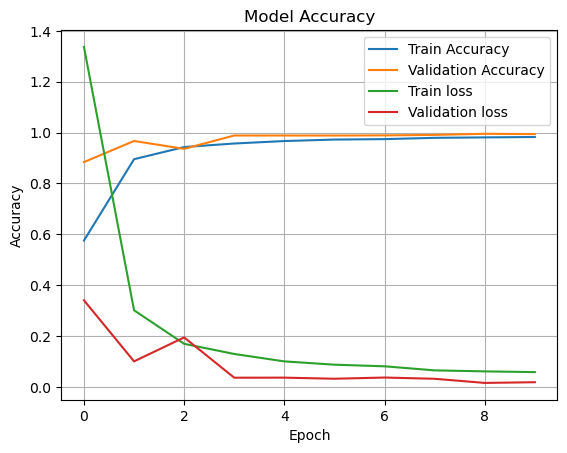

In [66]:
plt.plot(Model.history.history['accuracy'], label='Train Accuracy')
plt.plot(Model.history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(Model.history.history['loss'], label='Train loss')
plt.plot(Model.history.history['val_loss'], label='Validation loss')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Предположим, что переменная model — это ваша обученная модель
Model.save("asl_model.h5")
print("Модель сохранена в файл asl_model.h5")

Модель сохранена в файл asl_model.h5
